In [1]:
!git clone https://github.com/CornerSiow/zero-shot-image-captioning.git
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

Cloning into 'zero-shot-image-captioning'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 155 (delta 31), reused 0 (delta 0), pack-reused 89
Receiving objects: 100% (155/155), 75.77 MiB | 42.26 MiB/s, done.
Resolving deltas: 100% (70/70), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-hkm4on2o
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-hkm4on2o
     |████████████████████████████████| 50 kB 3.2 MB/s 
     |████████████████████████████████| 79 kB 6.0 MB/s 
     |████████████████████████████████| 151 kB 31.0 MB/s 
     |████████████████████████████████| 1.4 MB 69.1 MB/s 
     |████████████████████████████████| 548 kB 67.5 MB/s 
     |████████████████████████████████| 248 kB 66.8 MB/s 
  Inst

In [2]:
!cp "zero-shot-image-captioning/code/Vocabulary.py" "Vocabulary.py"
!cp "zero-shot-image-captioning/code/DecoderLSTM.py" "DecoderLSTM.py"
!cp "zero-shot-image-captioning/code/Places365.py" "Places365.py"

In [3]:
import torch
from DecoderLSTM import DecoderLSTM
from Vocabulary import Vocabulary
import pickle
from Places365 import Places365
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
import cv2
import os
import numpy as np

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
place365 = Places365()
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
cfg.MODEL.DEVICE = str(device)
detectron2 = DefaultPredictor(cfg)
with open('zero-shot-image-captioning/data/filtered_symbolic.pickle', 'rb') as handle:
    filtered_symbolic = pickle.load(handle)  
vocab = Vocabulary()
vocab.loadFile("zero-shot-image-captioning/data/vocab.pickle")
vocab_size = len(vocab)
embed_size = len(filtered_symbolic)
hidden_size = 256 

model_final_cafdb1.pkl: 261MB [00:08, 32.5MB/s]                           


In [5]:
decoder = DecoderLSTM(embed_size, hidden_size, vocab_size)
decoder.load_state_dict(torch.load('zero-shot-image-captioning/data/lstm_decoder.pkl'))
decoder.to(device)
decoder.eval()

DecoderLSTM(
  (embedding): Embedding(30, 8)
  (lstm): LSTM(8, 256, bias=False, batch_first=True)
  (linear): Linear(in_features=256, out_features=30, bias=True)
)

In [6]:
def getImageSymbolics(img_path, threshold = 0.6):

    result = place365.pred(img_path)
   
    im = cv2.imread(img_path)        
    panoptic_seg, segments_info = detectron2(im)["panoptic_seg"]
    meta = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

    stuffClass = meta.stuff_classes
    thingClass = meta.thing_classes

    stuffResult = []
    thingResult = []
    areaSize = 0
    
    for v in segments_info:        
        if v['isthing']:
            thingResult.append([thingClass[v['category_id']].replace("-", " ").replace("/", " ").replace("_", " "), v['score']])    
        else:
            areaSize += v['area']
            stuffResult.append([stuffClass[v['category_id']].replace("-", " ").replace("/", " ").replace("_", " "), v['area']])

    
    for v in thingResult:
            if v[0] not in result:
                result[v[0]] = 0
            result[v[0]] += v[1]
    
    
    for v in stuffResult:     
            if v[0] not in result:
                result[v[0]] = 0
            result[v[0]] += v[1]/areaSize
    
    symbolics = {}
    for r in result:
        if result[r] > threshold:
            symbolics[r] = result[r]
 
    return symbolics

In [ ]:
results = []
for filename in os.scandir("zero-shot-image-captioning/img_test"):
  if filename.path.endswith('jpg'):
    symbolics = getImageSymbolics(filename.path)
    inputs = np.zeros(len(filtered_symbolic))

    for s in symbolics:
        if s.replace(" ", "_") in filtered_symbolic:
          inputs[filtered_symbolic.index(s.replace(" ", "_"))] = symbolics[s]
    
    inputs = torch.from_numpy(inputs).float()
    inputs = inputs.unsqueeze(0).unsqueeze(0).float().to(device)
    output = decoder.sample(inputs)    
    sentence = vocab.clean_sentence(output)        
    print(filename.name, sentence)
    results.append({
        'name' : filename.name,
        'path' : filename.path,
        'caption': sentence
    })

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


cycling_1.jpg  a person riding a bike on a clear sky
working_1.jpg  a person using a laptop in the office
working_2.jpg  a person using a laptop in the office
bus_1.jpg  someone is waiting at the bus stop
cycling_2.jpg  a person riding a bike on a clear sky
eating_2.jpg  a person eats a banana in front of a laptop


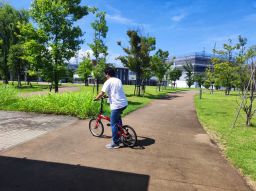

 a person riding a bike on a clear sky


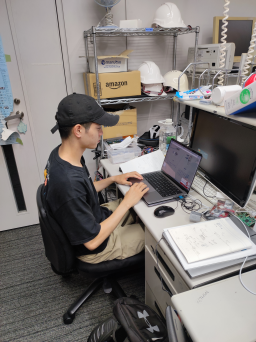

 a person using a laptop in the office


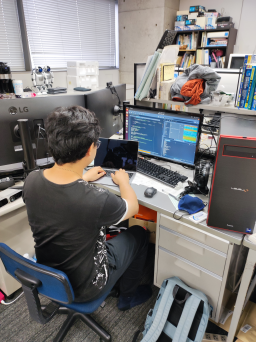

 a person using a laptop in the office


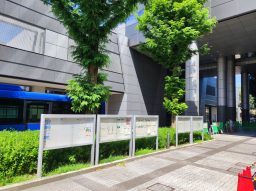

 someone is waiting at the bus stop


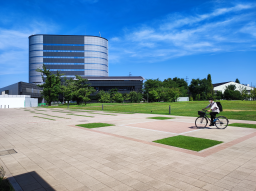

 a person riding a bike on a clear sky


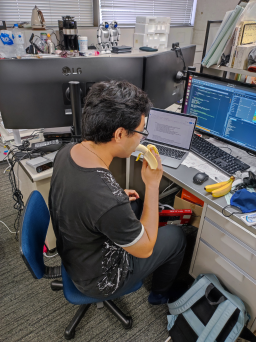

 a person eats a banana in front of a laptop


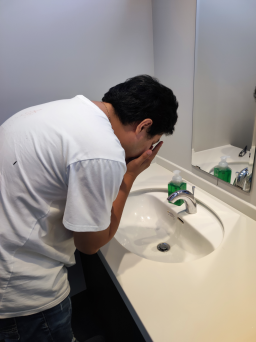

 a person washes his face in the sink


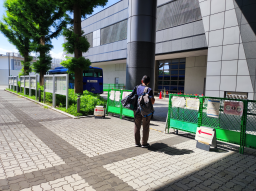

 someone is waiting at the bus stop


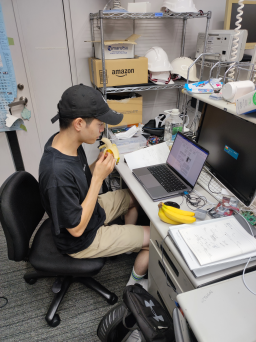

 a person eats a banana in front of a laptop


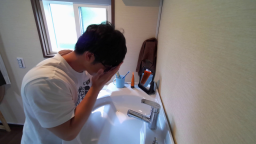

 a person washes his face in the sink


In [13]:
from google.colab.patches import cv2_imshow
for v in results:
  img = cv2.imread(v['path'], cv2.IMREAD_UNCHANGED)
  dim = None
  (h, w) = img.shape[:2]
  r = 256 / float(w)
  dim = (256, int(h * r))
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  cv2_imshow(resized)
  print(v['caption'])